In [10]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

### Download Historical Stock Data

In [2]:
# Download stock data for AAPL and MSFT from 2014 to 2024
aapl_data = yf.download("AAPL", start="2014-01-01", end="2024-01-01")
msft_data = yf.download("MSFT", start="2014-01-01", end="2024-01-01")

# Focus on adjusted closing price for both stocks
aapl_close = aapl_data['Adj Close']
msft_close = msft_data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


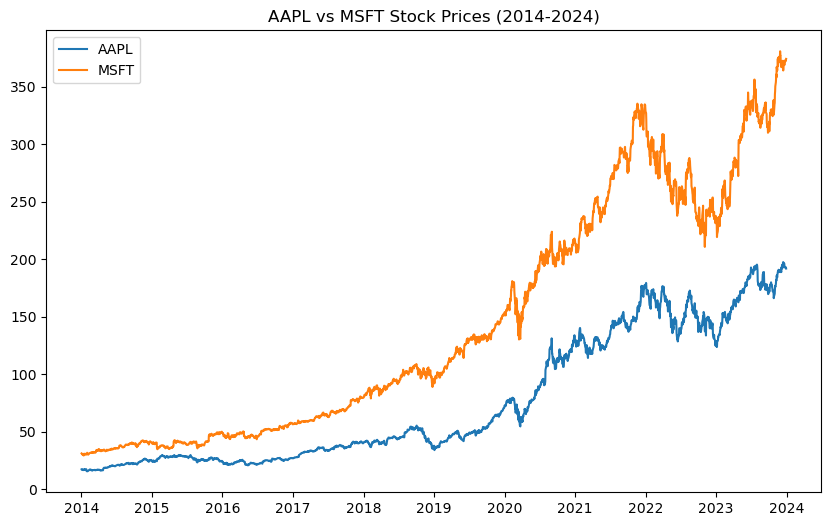

In [3]:

plt.figure(figsize=(10, 6))
plt.plot(aapl_close, label='AAPL')
plt.plot(msft_close, label='MSFT')
plt.title('AAPL vs MSFT Stock Prices (2014-2024)')
plt.legend()
plt.show()

### The Cointegration Test: Engle-Granger Two-Step Method

The most common cointegration test is the Engle-Granger test, which is a two-step process.

**Step 1: Estimate the Long-Run Relationship**

The first step is to run a simple linear regression between the two time series. For example, if we have two stock price series $P_A$ (AAPL) and $P_M$​ (MSFT), we fit the following regression model:
$$
P_A(t)=α+βP_M(t)+ϵ(t)
$$

Where:
* $P_A(t)$ is the price of stock AAPL at time $t$,
* $P_M(t)$ is the price of stock MSFT at time $t$,
* $α$ is the intercept,
* $β$ is the hedge ratio or coefficient,
* $ϵ(t)$ is the residual, or the difference between the observed and predicted prices of AAPL.

In pairs trading, this residual, $ϵ(t)$, is effectively the "spread" between the two stocks.

**Step 2: Test the Residual for Stationarity**

After estimating the hedge ratio ($β$) and obtaining the residuals $ϵ(t)$, the next step is to check whether the residuals are stationary. This is done using the Augmented Dickey-Fuller (ADF) test.
* If the residuals are stationary, it means the two series are cointegrated. Even if the stock prices themselves are non-stationary, their spread reverts to a mean over time.
* If the residuals are not stationary, the two series are not cointegrated, meaning their relationship is not stable, and they may drift apart indefinitely.

We can perform the Engle-Granger test in Python using the `coint` function from `statsmodels`.

In [4]:
score, p_value, _ = coint(aapl_close, msft_close)

The p-value is the key output of the cointegration test.
* If the p-value is below a certain threshold (commonly 0.05), we reject the null hypothesis of no cointegration, meaning the series are cointegrated.
* If the p-value is above the threshold, we accept the null hypothesis, meaning the series are not cointegrated.

Null and Alternative Hypotheses:
* Null Hypothesis ($H_0$): There is no cointegration between the time series (the spread is not stationary)
* Alternative Hypothesis ($H_1$): There is cointegration between the time series (the spread is stationary)

In [5]:
print(f"Cointegration Test p-value: {p_value}")

Cointegration Test p-value: 0.13353526559258716


The p-value is 0.13354 (5 d.p.), indicating weak cointegration between AAPL and MSFT; however, we will still proceed with the strategy for the sake of exploring its logic.

### Calculate the Spread

The spread is the difference between the two stocks' price, potentially adjusted with a hedge ratio. We calculate the hedge ratio by regressing one stock's price against the other.

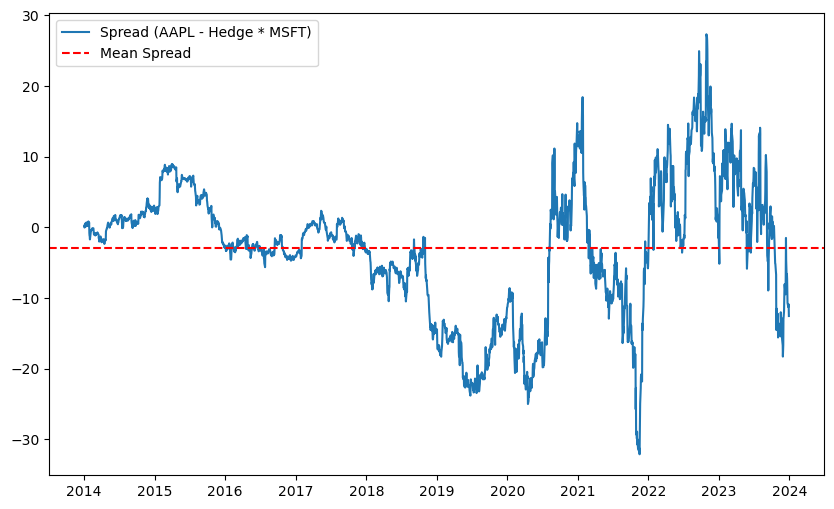

In [9]:
# Perform linear regression (AAPL ~ MSFT)
X = sm.add_constant(msft_close)
model = sm.OLS(aapl_close, X).fit()

# Extract hedge ratio
hedge_ratio = model.params.iloc[1]
intercept = model.params.iloc[0]

# Calculate spread
spread = aapl_close - hedge_ratio * msft_close

# Plot spread
plt.figure(figsize=(10, 6))
plt.plot(spread, label='Spread (AAPL - Hedge * MSFT)')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean Spread')
plt.legend()
plt.show()